# Transformaciones de Datos para Métricas de Atención al Cliente en ACME

*Nota: En este notebook se usan datos 'dummy' generados para obtener un resultado más significativo.*

Este notebook ha sido diseñado para realizar transformaciones sobre los datos disponibles en el Datalake de ACME, con el fin de preparar un conjunto de tablas que serán utilizadas por el equipo de BI para el desarrollo de un tablero de control. La meta principal de estas transformaciones es dar seguimiento y análisis a las métricas clave relacionadas con el sector de atención al cliente.

### Justificación del Enfoque
En este challenge, opté por utilizar Jupyter Notebook para realizar las transformaciones y consultas requeridas. La elección de este enfoque se basó más que nada en demostrar el proceso de forma paso a paso y mantener la transparencia del análisis. Decidí trabajar con los datos de ejemplo proporcionados y cargarlos en  DataFrames que simulan las tablas. Luego, los datos fueron manipulados utilizando SQLite para llevar a cabo las consultas y transformaciones necesarias.

### 1. Cargar datos desde CSV

In [77]:
# Importar librerías
import pandas as pd
import sqlite3

# Leer los archivos CSV, que contienen las tablas de ejemplo
df_interacciones = pd.read_csv('interacciones.csv')
df_nps = pd.read_csv('nps_surveys.csv')
df_representantes = pd.read_csv('representantes.csv')

# Mostrar las primeras filas para verificar
print("Interacciones:")
print(df_interacciones.head())

print("\nNPS:")
print(df_nps.head())

print("\nRepresentantes:")
print(df_representantes.head())


Interacciones:
   case_id  interaction_id interaction_type representante    int_date
0       32            1132  rep_case_closed    ggutierrez  2020-05-08
1       33            1133   user_recontact           NaN  2020-11-05
2       34            1134     user_contact           NaN  2020-09-13
3       35            1135     rep_response         pcruz  2020-08-10
4       36            1136     rep_response         pcruz  2020-09-22

NPS:
   survey_id  case_id  nps_score                      ps_comment
0          2       32          7                             NaN
1          3       33          6                             NaN
2          4       34         10                             NaN
3          5       35          0  No cumplieron mis expectativas
4          6       36          5                No me gusto nada

Representantes:
  Representante         full_name  team incoming_date    status
0    ggutierrez  Gaston Gutierrez     2    2017-11-28  Inactive
1        jperez        J

### 2. Crear una base de datos SQLite y cargar tablas

In [78]:
# Crear una base de datos SQLite en memoria
conn = sqlite3.connect(":memory:")

# Cargar los DataFrames como tablas en SQLite
df_interacciones.to_sql('interacciones', conn, index=False, if_exists='replace')
df_nps.to_sql('nps', conn, index=False, if_exists='replace')
df_representantes.to_sql('representantes', conn, index=False, if_exists='replace')

# Verificar que las tablas se hayan creado correctamente
print("\nTablas en SQLite:")
print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn))



Tablas en SQLite:
             name
0   interacciones
1             nps
2  representantes


### 3. Consultas SQL

In [79]:
# Consulta SQL: Calcular el promedio de nps_score por case_id
query_avg_nps = """
SELECT
    case_id,
    AVG(nps_score) AS avg_nps_score
FROM
    nps
GROUP BY
    case_id;
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
df_avg_nps = pd.read_sql(query_avg_nps, conn)

print("\nPromedio de NPS por case_id:")
print(df_avg_nps.head())


Promedio de NPS por case_id:
   case_id  avg_nps_score
0       32            7.0
1       33            6.0
2       34           10.0
3       35            0.0
4       36            5.0


In [80]:
# Consulta SQL: Categorizar casos como 'derivado' y 'no_derivado'
query_categorias = """
SELECT
    *,
    CASE
        WHEN interaction_type = 'rep_derivation' THEN 'derivado'
        ELSE 'no_derivado'
    END AS referral_status
FROM
    interacciones;
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
df_categorias = pd.read_sql(query_categorias, conn)

print("\nCategorías para referral_status:")
print(df_categorias[['case_id', 'interaction_type', 'referral_status']].head())



Categorías para referral_status:
   case_id interaction_type referral_status
0       32  rep_case_closed     no_derivado
1       33   user_recontact     no_derivado
2       34     user_contact     no_derivado
3       35     rep_response     no_derivado
4       36     rep_response     no_derivado


In [81]:
# Consulta SQL: Contar promotores, detractores y el total general
query_counts = """
SELECT
    COUNT(CASE WHEN nps_score BETWEEN 9 AND 10 THEN 1 END) AS cantidad_promotores,
    COUNT(CASE WHEN nps_score BETWEEN 0 AND 6 THEN 1 END) AS cantidad_detractores,
    COUNT(*) AS total_general
FROM
    nps;
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
df_counts = pd.read_sql(query_counts, conn)

print("\nConteo de Promotores, Detractores y Total General:")
print(df_counts)



Conteo de Promotores, Detractores y Total General:
   cantidad_promotores  cantidad_detractores  total_general
0                  312                   354           1000


In [82]:
# Consulta SQL: Calcular NPS por referral_status
query_nps_referral = """
SELECT
    referral_status,
    COUNT(CASE WHEN nps_score BETWEEN 9 AND 10 THEN 1 END) AS cantidad_promotores,
    COUNT(CASE WHEN nps_score BETWEEN 0 AND 6 THEN 1 END) AS cantidad_detractores,
    COUNT(*) AS total_encuestas,
    (CAST(COUNT(CASE WHEN nps_score BETWEEN 9 AND 10 THEN 1 END) AS FLOAT) -
     COUNT(CASE WHEN nps_score BETWEEN 0 AND 6 THEN 1 END))/
     COUNT(*) AS np
FROM (
    SELECT
        i.case_id,
        CASE
            WHEN i.interaction_type = 'rep_derivation' THEN 'derivado'
            ELSE 'no_derivado'
        END AS referral_status,
        n.nps_score
    FROM
        interacciones i
    LEFT JOIN
        nps n ON i.case_id = n.case_id
)
GROUP BY
    referral_status;
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
df_nps_referral = pd.read_sql(query_nps_referral, conn)

print("\nNPS por referral_status:")
print(df_nps_referral)



NPS por referral_status:
  referral_status  cantidad_promotores  cantidad_detractores  total_encuestas   
0        derivado                   60                    59              170  \
1     no_derivado                  252                   295              830   

         np  
0  0.005882  
1 -0.051807  



NPS por equipo y por mes:
      month  team  cantidad_promotores  cantidad_detractores  total_encuestas   
0   2020-01     1                    3                     1                5  \
1   2020-01     2                    6                    11               27   
2   2020-01     3                    3                     1                5   
3   2020-02     1                    1                     4                8   
4   2020-02     2                    8                     8               23   
5   2020-02     3                    2                     2                6   
6   2020-03     1                    5                     3                9   
7   2020-03     2                   10                     7               29   
8   2020-03     3                    1                     1                4   
9   2020-04     1                    3                     1                8   
10  2020-04     2                   10                     7               26   
1

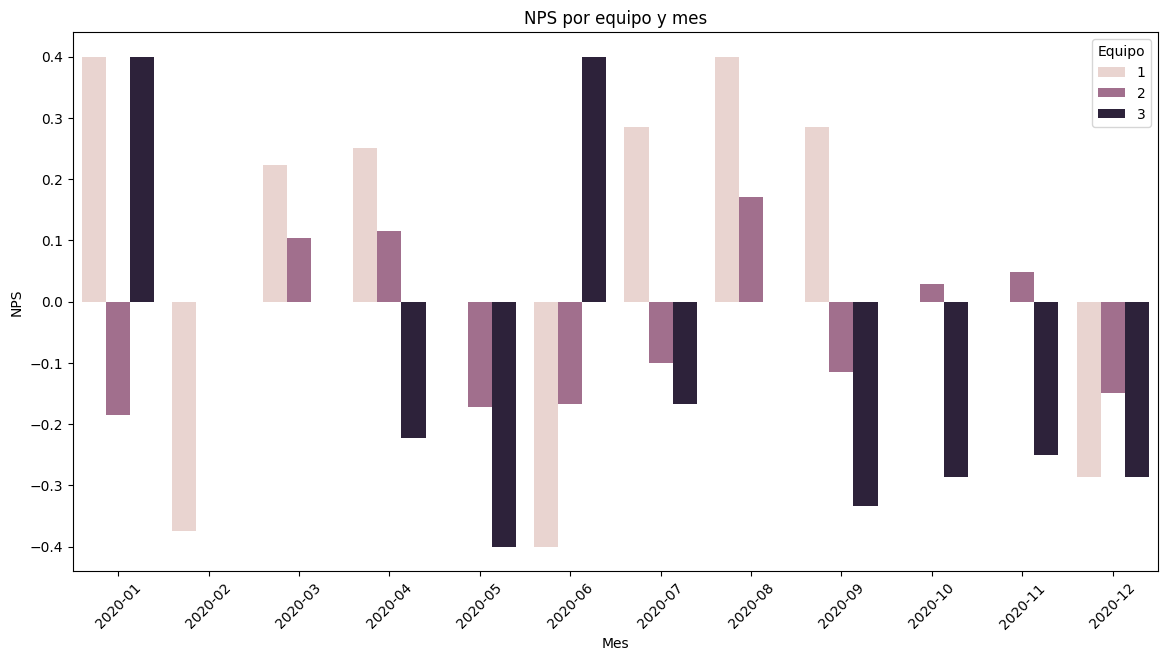

In [83]:
# Ejecutar la consulta y cargar los resultados en un DataFrame
query_nps_por_equipo = """
SELECT
    strftime('%Y-%m', i.int_date) AS month,
    r.team,
    COUNT(DISTINCT CASE WHEN s.nps_score BETWEEN 9 AND 10 THEN s.case_id END) AS cantidad_promotores,
    COUNT(DISTINCT CASE WHEN s.nps_score BETWEEN 0 AND 6 THEN s.case_id END) AS cantidad_detractores,
    COUNT(DISTINCT s.case_id) AS total_encuestas,
    ((COUNT(DISTINCT CASE WHEN s.nps_score BETWEEN 9 AND 10 THEN s.case_id END) -
      COUNT(DISTINCT CASE WHEN s.nps_score BETWEEN 0 AND 6 THEN s.case_id END)) * 1.0 /
     COUNT(DISTINCT s.case_id)) AS nps
FROM
    interacciones i
JOIN
    representantes r ON i.representante = r.representante
LEFT JOIN
    nps s ON i.case_id = s.case_id
WHERE
    i.interaction_type IN ('rep_response', 'rep_derivation', 'rep_case_closed')
GROUP BY
    month, r.team
ORDER BY
    month, r.team;
"""

# Ejecutar la consulta y cargar el resultado en un DataFrame
df_nps_por_equipo = pd.read_sql(query_nps_por_equipo, conn)

# Mostrar el resultado
print("\nNPS por equipo y por mes:")
print(df_nps_por_equipo)

# Visualización opcional: gráfico de barras para ver el NPS por equipo y mes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(data=df_nps_por_equipo, x='month', y='nps', hue='team')
plt.title('NPS por equipo y mes')
plt.xlabel('Mes')
plt.ylabel('NPS')
plt.xticks(rotation=45)
plt.legend(title='Equipo')
plt.show()
